In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns 

from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# --- CONFIG ---
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# --- LOAD FROM CACHE OR FETCH ---
if os.path.exists(tickers_csv_file):
    print("Loading tickers from CSV cache...")
    df_sp500 = pd.read_csv(tickers_csv_file)
else:
    print("Fetching tickers from API...")
    url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"
    df_sp500 = pd.DataFrame(requests.get(url).json())

    # Save to CSV
    df_sp500.to_csv(tickers_csv_file, index=False)
    print(f"Saved {len(df_sp500)} tickers to CSV cache.")

    
tickers = df_sp500["symbol"].dropna().unique().tolist()
# --- PREVIEW ---
print(df_sp500.shape)
print(df_sp500.columns)
print(df_sp500.head(5))

Loading tickers from CSV cache...
(503, 8)
Index(['symbol', 'name', 'sector', 'subSector', 'headQuarter',
       'dateFirstAdded', 'cik', 'founded'],
      dtype='object')
  symbol                  name                  sector  \
0    XYZ           Block, Inc.              Technology   
1    TTD  The Trade Desk, Inc.              Technology   
2   DDOG               Datadog              Technology   
3   COIN       Coinbase Global      Financial Services   
4   DASH              DoorDash  Communication Services   

                            subSector              headQuarter dateFirstAdded  \
0           Software - Infrastructure      Oakland, California     2025-07-23   
1              Software - Application      Ventura, California     2025-07-18   
2              Software - Application  New York City, New York     2025-07-09   
3  Financial - Data & Stock Exchanges     Wilmington, Delaware     2025-05-19   
4      Internet Content & Information        San Francisco, CA     2025-03

In [3]:
def fetch_statement(endpoint, tickers, period, limit, data_folder):
    """Fetch statements with unique JSON filename based on endpoint, period, limit."""
    output_file = os.path.join(
        data_folder,
        f"{endpoint}_{period}_limit{limit}.json"
    )

    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        with open(output_file, "r") as f:
            return json.load(f)

    records = []
    for ticker in tickers:
        url = f"https://financialmodelingprep.com/api/v3/{endpoint}/{ticker}?period={period}&limit={limit}&apikey={API_KEY}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                for row in data:
                    row["symbol"] = ticker
                records.extend(data)
        except Exception as e:
            print(f"Error fetching {ticker} ({endpoint}): {e}")
        time.sleep(.2)  # API polite rate limit

    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")
    return records


income_data_2_years   = fetch_statement("income-statement", tickers, "annual", 2, data_folder)
balance_data_2_years  = fetch_statement("balance-sheet-statement", tickers, "annual", 2, data_folder)
cashflow_data_2_years = fetch_statement("cash-flow-statement", tickers, "annual", 2, data_folder)

# Convert to DataFrames
income_data_2_years   = pd.DataFrame(income_data_2_years)
balance_data_2_years  = pd.DataFrame(balance_data_2_years)
cashflow_data_2_years = pd.DataFrame(cashflow_data_2_years)

print("Income shape:", income_data_2_years.shape)
print("Balance shape:", balance_data_2_years.shape)
print("Cash flow shape:", cashflow_data_2_years.shape)

print(income_data_2_years.columns)
print(balance_data_2_years.columns)
print(cashflow_data_2_years.columns)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/income-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/balance-sheet-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/cash-flow-statement_annual_limit2.json
Income shape: (1006, 38)
Balance shape: (1006, 54)
Cash flow shape: (1006, 40)
Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
  

In [4]:
def sort_by_symbol_date(df):
    return df.sort_values(["symbol", "date"])


def compute_yoy_growth(df, exclude_cols=["symbol", "date","link","finalLink"]):
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
    
    df_growth = df.copy()
    for col in numeric_cols:
        df_growth[col + "_yoy"] = df.groupby("symbol")[col].pct_change()
    
    return df_growth


income_sorted = sort_by_symbol_date(income_data_2_years)
balance_sorted = sort_by_symbol_date(balance_data_2_years)
cashflow_sorted = sort_by_symbol_date(cashflow_data_2_years)

income_growth = compute_yoy_growth(income_sorted)
balance_growth = compute_yoy_growth(balance_sorted)
cashflow_growth = compute_yoy_growth(cashflow_sorted)

In [5]:
def count_zeros_nans_yoy(df):
    # Keep only numeric columns that end with "_yoy"
    numeric_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    
    # Count zeros and NaNs
    zero_counts = (df[numeric_cols] == 0).sum()
    nan_counts = df[numeric_cols].isna().sum()
    
    # Combine into a single DataFrame
    summary = pd.DataFrame({
        "zeros": zero_counts,
        "nans": nan_counts
    }).sort_values(by=["zeros", "nans"], ascending=True)
    
    # Force full display
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        print(summary)
    
    return summary

# Example usage
print("Income 0/NaN counts per YoY column:")
income_summary = count_zeros_nans_yoy(income_growth)

print("\nBalance 0/NaN counts per YoY column:")
balance_summary = count_zeros_nans_yoy(balance_growth)

print("\nCashflow 0/NaN counts per YoY column:")
cashflow_summary = count_zeros_nans_yoy(cashflow_growth)

Income 0/NaN counts per YoY column:
                                             zeros  nans
revenue_yoy                                      0   503
grossProfit_yoy                                  0   503
costAndExpenses_yoy                              0   503
ebitdaratio_yoy                                  0   503
operatingIncome_yoy                              0   503
operatingIncomeRatio_yoy                         0   503
incomeBeforeTax_yoy                              0   503
incomeBeforeTaxRatio_yoy                         0   503
netIncomeRatio_yoy                               0   503
ebitda_yoy                                       0   504
operatingExpenses_yoy                            0   507
costOfRevenue_yoy                                0   510
totalOtherIncomeExpensesNet_yoy                  0   535
generalAndAdministrativeExpenses_yoy             0   756
netIncome_yoy                                    1   503
eps_yoy                                          1  

def prepare_for_pca(df, nan_threshold=505, n_components=5):
    # 1. Keep only _yoy numeric columns
    yoy_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    sub_df = df[yoy_cols].copy()
    
    # 2. Drop columns with too many NaNs
    valid_cols = sub_df.columns[sub_df.isna().sum() <= nan_threshold]
    sub_df = sub_df[valid_cols]
    
    # 3. Replace infinities with NaN
    sub_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 4. Drop rows with any remaining NaNs
    sub_df.dropna(inplace=True)
    
    # Count how many rows are being used
    row_count = sub_df.shape[0]
    
    # 5. Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(sub_df)
    
    # 6. Run PCA
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled)
    
    # Convert back to DataFrame
    pcs_df = pd.DataFrame(
        pcs,
        index=sub_df.index,
        columns=[f"PC{i+1}" for i in range(n_components)]
    )
    
    return pcs_df, pca, scaler, valid_cols, row_count



In [6]:
def prepare_for_pca(df, nan_threshold=505, n_components=5):
    # 1. Keep only _yoy numeric columns
    yoy_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    sub_df = df[yoy_cols].copy()
    
    # 2. Drop columns with too many NaNs
    valid_cols = sub_df.columns[sub_df.isna().sum() <= nan_threshold]
    
    # --- Print columns that made it through the NaN filter ---
    print(f"Columns kept (<= {nan_threshold} NaNs):")
    for col in valid_cols:
        print(f"  {col} (NaNs: {sub_df[col].isna().sum()})")
    
    sub_df = sub_df[valid_cols]
    
    # 3. Replace infinities with NaN
    sub_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 4. Drop rows with any remaining NaNs
    sub_df.dropna(inplace=True)
    
    # Count how many rows are being used
    row_count = sub_df.shape[0]
    
    # 5. Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(sub_df)
    
    # 6. Run PCA
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled)
    
    # Convert back to DataFrame
    pcs_df = pd.DataFrame(
        pcs,
        index=sub_df.index,
        columns=[f"PC{i+1}" for i in range(n_components)]
    )
    
    return pcs_df, pca, scaler, valid_cols, row_count


In [7]:
# Run PCA on Income
income_pcs, income_pca_model, income_scaler, income_used_cols, income_row_count = prepare_for_pca(
    income_growth, nan_threshold=503, n_components=5
)

# Run PCA on Balance
balance_pcs, balance_pca_model, balance_scaler, balance_used_cols, balance_row_count = prepare_for_pca(
    balance_growth, nan_threshold=503, n_components=5
)

# Run PCA on Cashflow
cashflow_pcs, cashflow_pca_model, cashflow_scaler, cashflow_used_cols, cashflow_row_count = prepare_for_pca(
    cashflow_growth, nan_threshold=503, n_components=5
)

# Print summary
print("Income PCA shape:", income_pcs.shape, "| Rows used:", income_row_count)
print("Balance PCA shape:", balance_pcs.shape, "| Rows used:", balance_row_count)
print("Cashflow PCA shape:", cashflow_pcs.shape, "| Rows used:", cashflow_row_count)


Columns kept (<= 503 NaNs):
  revenue_yoy (NaNs: 503)
  grossProfit_yoy (NaNs: 503)
  grossProfitRatio_yoy (NaNs: 503)
  costAndExpenses_yoy (NaNs: 503)
  ebitdaratio_yoy (NaNs: 503)
  operatingIncome_yoy (NaNs: 503)
  operatingIncomeRatio_yoy (NaNs: 503)
  incomeBeforeTax_yoy (NaNs: 503)
  incomeBeforeTaxRatio_yoy (NaNs: 503)
  netIncome_yoy (NaNs: 503)
  netIncomeRatio_yoy (NaNs: 503)
  eps_yoy (NaNs: 503)
  epsdiluted_yoy (NaNs: 503)
  weightedAverageShsOut_yoy (NaNs: 503)
  weightedAverageShsOutDil_yoy (NaNs: 503)
Columns kept (<= 503 NaNs):
  cashAndCashEquivalents_yoy (NaNs: 503)
  cashAndShortTermInvestments_yoy (NaNs: 503)
  otherNonCurrentAssets_yoy (NaNs: 503)
  totalAssets_yoy (NaNs: 503)
  totalLiabilities_yoy (NaNs: 503)
  totalStockholdersEquity_yoy (NaNs: 503)
  totalEquity_yoy (NaNs: 503)
  totalLiabilitiesAndStockholdersEquity_yoy (NaNs: 503)
  totalLiabilitiesAndTotalEquity_yoy (NaNs: 503)
  netDebt_yoy (NaNs: 503)
Columns kept (<= 503 NaNs):
  netIncome_yoy (NaNs: 50

In [16]:
def run_pca_on_selected_yoy_clean(df, selected_yoy_cols, n_components=5, keep_cols=["symbol","date"]):
    """
    df: DataFrame with growth data (includes _yoy columns)
    selected_yoy_cols: list of yoy column names you want to use in PCA
    n_components: number of PCA components
    keep_cols: reference columns to carry over (like symbol, date)
    """
    # Make sure selected columns exist
    missing = [c for c in selected_yoy_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Some selected yoy columns not found in DataFrame: {missing}")
    
    # Extract the selected yoy data
    X = df[selected_yoy_cols].copy()
    
    # Replace infinite with NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows with any NaN in selected columns
    mask_valid = ~X.isna().any(axis=1)
    X_clean = X[mask_valid]
    
    # Keep symbol/date for those same rows
    meta = df.loc[mask_valid, keep_cols].reset_index(drop=True)
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # Run PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_scaled)
    
    # Build PCA DataFrame
    pca_df = pd.DataFrame(components, columns=[f"PCA{i+1}" for i in range(n_components)])
    for col in keep_cols:
        if col in meta.columns:
            pca_df[col] = meta[col].values
    
    # Print info about rows used and columns included
    print(f"PCA shape: {pca_df.shape} | Rows used: {X_clean.shape[0]}")
    print(f"Columns used for PCA: {list(X_clean.columns)}")
    
    return pca_df, pca.explained_variance_ratio_


In [9]:
# Example, pick a few yoy columns you trust
income_cols = ["revenue_yoy","netIncome_yoy","ebitda_yoy","operatingIncome_yoy"]
balance_cols = ["totalAssets_yoy","totalLiabilities_yoy","totalStockholdersEquity_yoy"]
cashflow_cols = ["operatingCashFlow_yoy","freeCashFlow_yoy","netCashProvidedByOperatingActivities_yoy"]

income_pca, income_var = run_pca_on_selected_yoy_clean(income_growth, income_cols, n_components=3)
balance_pca, balance_var = run_pca_on_selected_yoy_clean(balance_growth, balance_cols, n_components=3)
cashflow_pca, cashflow_var = run_pca_on_selected_yoy_clean(cashflow_growth, cashflow_cols, n_components=3)

PCA shape: (502, 5) | Rows used: 502
Columns used for PCA: ['revenue_yoy', 'netIncome_yoy', 'ebitda_yoy', 'operatingIncome_yoy']
PCA shape: (503, 5) | Rows used: 503
Columns used for PCA: ['totalAssets_yoy', 'totalLiabilities_yoy', 'totalStockholdersEquity_yoy']
PCA shape: (503, 5) | Rows used: 503
Columns used for PCA: ['operatingCashFlow_yoy', 'freeCashFlow_yoy', 'netCashProvidedByOperatingActivities_yoy']


In [10]:
print("Explained variance ratio:", income_var)
print("Total explained variance:", income_var.sum())

Explained variance ratio: [0.29256159 0.25992356 0.23161683]
Total explained variance: 0.7841019824421284


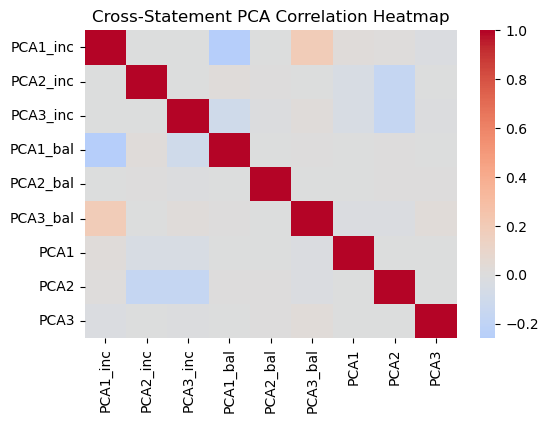

In [11]:
# Merge the three PCA results on symbol/date
merged_pca = income_pca.merge(balance_pca, on=["symbol","date"], suffixes=("_inc", "_bal"))
merged_pca = merged_pca.merge(cashflow_pca, on=["symbol","date"], suffixes=("", "_cf"))

# Get only PCA columns
pca_cols = [c for c in merged_pca.columns if c.startswith("PCA")]

# Compute correlation matrix
corr_all = merged_pca[pca_cols].corr()

# Display as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_all, annot=False, cmap="coolwarm", center=0)
plt.title("Cross-Statement PCA Correlation Heatmap")
plt.show()


In [12]:
# --- CONFIG ---
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# Load tickers
df_sp500 = pd.read_csv(tickers_csv_file)
tickers = df_sp500["symbol"].dropna().unique().tolist()

# Output file
output_file = os.path.join(data_folder, "price_and_earnings.json")

def fetch_price_and_earnings(tickers, output_file):
    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        return pd.DataFrame(json.load(open(output_file)))

    records = []
    for ticker in tickers:
        try:
            # Get current price
            quote_url = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?apikey={API_KEY}"
            price_data = requests.get(quote_url).json()
            if not price_data:
                continue
            price = price_data[0]["price"]

            # Get latest annual income statement (EPS or netIncome)
            income_url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}"
            income_data = requests.get(income_url).json()
            if not income_data:
                continue
            eps = income_data[0].get("eps")
            net_income = income_data[0].get("netIncome")

            records.append({
                "symbol": ticker,
                "price": price,
                "eps": eps,
                "netIncome": net_income
            })

        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(0.2)  # polite rate limit

    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")

    return pd.DataFrame(records)

# Fetch or load
price_earnings_df = fetch_price_and_earnings(tickers, output_file)
print(price_earnings_df.head())


Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/price_and_earnings.json
  symbol   price    eps   netIncome
0    XYZ   72.87   4.70  2897047000
1    TTD   45.15   0.80   393076000
2   DDOG  136.50   0.55   183746000
3   COIN  323.04  10.42  2579066000
4   DASH  257.98   0.30   123000000


In [13]:
# Compute log(PE)
price_earnings_df = price_earnings_df.copy()
price_earnings_df = price_earnings_df[price_earnings_df["eps"] > 0]  # remove zero or negative EPS
price_earnings_df["log_PE"] = np.log(price_earnings_df["price"] / price_earnings_df["eps"])

# Print row count
print("Number of rows after filtering EPS > 0:", len(price_earnings_df))


Number of rows after filtering EPS > 0: 480


In [14]:
# --- 2. Merge with PCA DataFrame ---
# Example: merging with income PCA; can merge balance/cashflow similarly
merged_df = income_pca.merge(
    price_earnings_df[["symbol", "log_PE"]],
    on="symbol",
    how="inner"
)

# If you want, merge balance and cashflow PCA as well
merged_df = merged_df.merge(balance_pca, on=["symbol","date"], suffixes=("","_bal"))
merged_df = merged_df.merge(cashflow_pca, on=["symbol","date"], suffixes=("","_cf"))

# --- 3. Preview ---
print(merged_df.head())
print("Shape of merged dataset:", merged_df.shape)

       PCA1      PCA2      PCA3 symbol        date    log_PE  PCA1_bal  \
0  0.166445 -0.029621  0.011421   AAPL  2024-09-28  3.645693 -0.117071   
1  0.147716 -0.007885 -0.027841   ABBV  2024-12-31  4.510585 -0.381441   
2 -0.338101 -0.068633 -0.173326   ABNB  2024-12-31  3.375818 -0.339876   
3  0.051022  0.050279  0.038192    ABT  2024-12-31  2.858506 -0.033720   
4 -0.876190  0.012107 -0.402497   ACGL  2024-12-31  2.084876  1.116383   

   PCA2_bal  PCA3_bal   PCA1_cf   PCA2_cf   PCA3_cf  
0  0.158074  0.114647 -0.070535 -0.024565 -0.000009  
1  0.759367  0.211749 -0.038525 -0.070200 -0.000009  
2 -0.023883  0.011606 -0.082483 -0.013360 -0.000009  
3 -0.194498 -0.447162 -0.084878  0.001688 -0.000009  
4  0.203819  0.064140 -0.082168 -0.013493 -0.000009  
Shape of merged dataset: (471, 12)


OLS Regression: log_PE ~ PCA1
                            OLS Regression Results                            
Dep. Variable:                 log_PE   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.326
Date:                Sat, 13 Sep 2025   Prob (F-statistic):             0.0381
Time:                        09:31:42   Log-Likelihood:                -543.68
No. Observations:                 471   AIC:                             1091.
Df Residuals:                     469   BIC:                             1100.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2943 

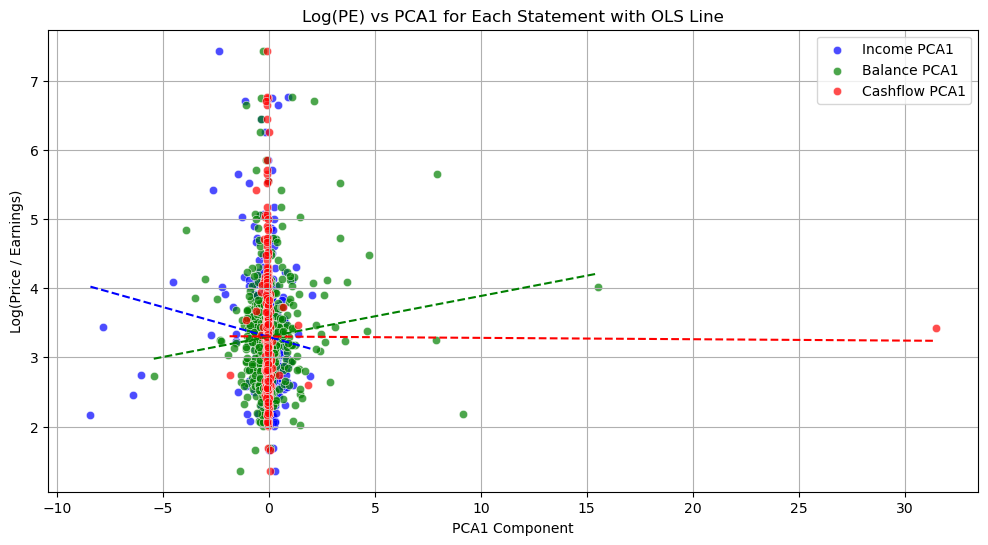

Multiple regression: log_PE ~ PCA1 + PCA1_bal + PCA1_cf
                            OLS Regression Results                            
Dep. Variable:                 log_PE   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.382
Date:                Sat, 13 Sep 2025   Prob (F-statistic):             0.0688
Time:                        09:31:43   Log-Likelihood:                -542.26
No. Observations:                 471   AIC:                             1093.
Df Residuals:                     467   BIC:                             1109.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [15]:
# Example: columns in merged_df
# 'PCA1', 'PCA1_bal', 'PCA1_cf', 'log_PE'

# --- 1. Separate regressions for each PCA1 ---
def run_ols_plot(x_col, y_col='log_PE', df=merged_df, color='blue', label=''):
    X = sm.add_constant(df[x_col])  # add intercept
    y = df[y_col]
    model = sm.OLS(y, X).fit()
    print(f"OLS Regression: {y_col} ~ {x_col}")
    print(model.summary())
    
    # Scatter + regression line
    sns.scatterplot(x=x_col, y=y_col, data=df, color=color, alpha=0.7, label=label)
    # Add regression line
    x_vals = np.linspace(df[x_col].min(), df[x_col].max(), 100)
    y_vals = model.params[0] + model.params[1]*x_vals
    plt.plot(x_vals, y_vals, color=color, linestyle='--')
    return model

plt.figure(figsize=(12,6))
model_income = run_ols_plot('PCA1', color='blue', label='Income PCA1')
model_balance = run_ols_plot('PCA1_bal', color='green', label='Balance PCA1')
model_cashflow = run_ols_plot('PCA1_cf', color='red', label='Cashflow PCA1')

plt.xlabel('PCA1 Component')
plt.ylabel('Log(Price / Earnings)')
plt.title('Log(PE) vs PCA1 for Each Statement with OLS Line')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Multiple regression including all three PCA1s ---
X_multi = merged_df[['PCA1','PCA1_bal','PCA1_cf']]
X_multi = sm.add_constant(X_multi)
y_multi = merged_df['log_PE']

multi_model = sm.OLS(y_multi, X_multi).fit()
print("Multiple regression: log_PE ~ PCA1 + PCA1_bal + PCA1_cf")
print(multi_model.summary())
